In [13]:
import yfinance as yf
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


In [14]:
years = 15

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365 * years)

In [15]:
tickers = ['SPY', 'BND', 'GLD', 'QQQ', 'VTI']

In [16]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate, auto_adjust= False)
    adj_close_df[ticker] = data['Adj Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2010-03-08   86.739998  51.822239  109.879997   40.642265   44.442268
2010-03-09   86.884193  51.854897  109.720001   40.869385   44.533871
2010-03-10   87.271347  51.815742  108.470001   41.201286   44.770538
2010-03-11   87.635674  51.809200  108.599998   41.358498   44.938454
2010-03-12   87.643295  51.828812  107.949997   41.367245   44.938454
...                ...        ...         ...         ...         ...
2025-02-24  597.210022  72.870003  272.209991  519.869995  294.410004
2025-02-25  594.239990  73.330002  268.619995  513.320007  292.950012
2025-02-26  594.539978  73.440002  269.029999  514.559998  293.049988
2025-02-27  585.049988  73.349998  264.929993  500.269989  288.510010
2025-02-28  594.179993  73.660004  263.269989  508.170013  292.959991

[3770 rows x 5 columns]


Calculate the Daily Log Returns

In [18]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()
print(log_returns)

                 SPY       BND       GLD       QQQ       VTI
Date                                                        
2010-03-09  0.001661  0.000630 -0.001457  0.005573  0.002059
2010-03-10  0.004446 -0.000755 -0.011458  0.008088  0.005300
2010-03-11  0.004166 -0.000126  0.001198  0.003808  0.003744
2010-03-12  0.000087  0.000378 -0.006003  0.000211  0.000000
2010-03-15  0.000260  0.001384  0.003791 -0.002537 -0.000340
...              ...       ...       ...       ...       ...
2025-02-24 -0.004561  0.001373  0.005415 -0.011875 -0.005116
2025-02-25 -0.004986  0.006293 -0.013276 -0.012679 -0.004971
2025-02-26  0.000505  0.001499  0.001525  0.002413  0.000341
2025-02-27 -0.016091 -0.001226 -0.015357 -0.028164 -0.015613
2025-02-28  0.015485  0.004217 -0.006286  0.015668  0.015306

[3769 rows x 5 columns]


Create an equally weighted PF

In [21]:
portfolio_value = 1000000
weight = np.array([1/len(tickers)]*len(tickers))
print(weight)

[0.2 0.2 0.2 0.2 0.2]


calculate hsitorical PF returns

In [23]:
historical_returns = (log_returns*weight).sum(axis = 1)
print(historical_returns)

Date
2010-03-09    0.001693
2010-03-10    0.001124
2010-03-11    0.002558
2010-03-12   -0.001065
2010-03-15    0.000512
                ...   
2025-02-24   -0.002953
2025-02-25   -0.005924
2025-02-26    0.001257
2025-02-27   -0.015290
2025-02-28    0.008878
Length: 3769, dtype: float64


In [24]:
days = 5

historical_x_day_returns = historical_returns.rolling(window = days).sum()

In [25]:
cov_matrix = log_returns.cov() * 252

In [26]:
portfolio_std_dev = np.sqrt(weight.T @ cov_matrix @ weight)

Set different confidence levels to visualise

In [27]:
confidence_levels = [0.9, 0.95, 0.99]

In [29]:
from scipy.stats import norm

VaRs = []

for cl in confidence_levels:
    VaR = portfolio_value * portfolio_std_dev * norm.ppf(cl) * np.sqrt(days/252)
    VaRs.append(VaR)

Print out the VaR results

In [34]:
print(f'{"Confidence Level": <20} {"Value at Risk":<20}')
print('-' * 40)

#Print each confiance level and its corresponding VaR valye
for cl, VaR in zip(confidence_levels, VaRs):
    print(f'{cl * 100: >6.0f}%: {'':<8} ${VaR:>10,.2f}')

Confidence Level     Value at Risk       
----------------------------------------
    90%:          $ 20,838.27
    95%:          $ 26,745.63
    99%:          $ 37,826.85


Graph the results

<function matplotlib.pyplot.show(close=None, block=None)>

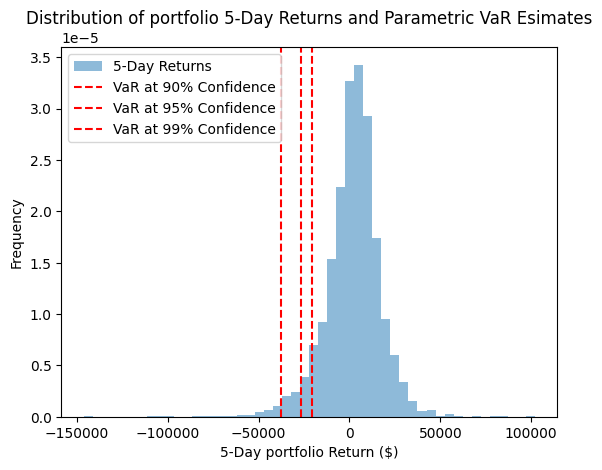

In [35]:
historical_x_day_returns_dollar = historical_x_day_returns * portfolio_value

plt.hist (historical_x_day_returns_dollar, bins = 50, density = True, alpha = 0.5, label = f'{days}-Day Returns')

for cl, VaR in zip(confidence_levels, VaRs):
    plt.axvline(x= -VaR, linestyle = '--', color = 'r', label = 'VaR at {}% Confidence'.format(int(cl*100)))

plt.xlabel(f'{days}-Day portfolio Return ($)')
plt.ylabel('Frequency')
plt.legend()
plt.title(f'Distribution of portfolio {days}-Day Returns and Parametric VaR Esimates')
plt.show